In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


from functions.parse_data import synth_dataloader
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import random

In [50]:
#Load data
df=synth_dataloader('SMHIdata2',drop_cols=False)
#Dumb down surfaces
df=hf.dumb_down_surface(df)

print(df.head())

#Load X_test and y_test
loadpath='pytorch_models/Final_model/data'
X_test = pd.read_csv(loadpath+'/X_test.csv',index_col=0)
y_test = pd.read_csv(loadpath+'/y_test.csv',index_col=0)


   Cloud_B01  Cloud_B02  Cloud_B03  Cloud_B04  Cloud_B05  Cloud_B06  \
0    0.95937    0.94195    0.87799    0.92936    0.93407    0.95181   
1    0.28649    0.30422    0.40100    0.27834    0.57800    1.01964   
2    0.30657    0.28715    0.25066    0.30366    0.29214    0.34088   
3    0.27930    0.27146    0.33719    0.19841    0.46411    0.88787   
4    0.42411    0.39689    0.38594    0.32623    0.37338    0.60678   

   Cloud_B07  Cloud_B08  Cloud_B08A  Cloud_B09  ...  Sat_Zenith_Angle  \
0    0.96217    0.92871     0.97181    0.49957  ...              4.53   
1    1.02787    1.00519     1.03599    0.59139  ...             12.85   
2    0.40079    0.37376     0.48750    0.02092  ...             14.53   
3    0.89584    0.87746     0.90439    0.51811  ...              6.54   
4    0.66895    0.55343     0.70168    0.01513  ...              8.56   

   Sun_Zenith_Angle  Azimuth_Diff_Angle    COT  Cloud_Type  Profile_ID    GOT  \
0             52.05              167.66  5.897       

In [51]:
#Load models
base_path = 'pytorch_models/Final_model/'
model_paths = ['model0/model_file','model1/model_file','model2/model_file','model3/model_file','model4/model_file']
#               'model5/model_file','model6/model_file','model7/model_file','model8/model_file','model9/model_file']
models = [torch.load(base_path+model_paths[i]) for i in range(len(model_paths))]

#Manually set quantiles
quantiles = np.array([0.1,0.5,0.9])
est = np.where(quantiles==0.5)[0].item()

#Initialize metric df
model_metrics=pd.DataFrame(columns=['Ensemble_mean','Ensemble_index','MSE','PSNR','R2_score','Mean_Quantile_Loss','Quantile_rate'])
#Make preds
preds_total=[]
#Make predictions and evaluate
for i,model in enumerate(models):
    preds = model.predict(X_test.to_numpy())
    #Find errors
    mse=mean_squared_error(y_test.to_numpy(),preds[:,:,est])
    psnr=QuantileNetwork.PSNR(y_test.to_numpy(),preds[:,:,est])
    r2=r2_score(y_test.to_numpy(),preds[:,:,est])
    mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds,quantiles)
    quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)
    #Add to dataframe
    tmp_metrics=pd.DataFrame(data=[[False,i,mse,psnr,r2,mean_quantile,quant_rate]],columns=['Ensemble_mean','Ensemble_index','MSE','PSNR','R2_score','Mean_Quantile_Loss','Quantile_rate'])
    model_metrics=pd.concat([model_metrics,tmp_metrics])
    #Keep track of ensemble prediction
    if i==0:
        preds_total=preds
    else:
        preds_total=preds_total+preds

#Now find ensemble predictions
preds_total=preds_total/len(model_paths)

#Find errors
mse=mean_squared_error(y_test.to_numpy(),preds_total[:,:,est])
psnr=QuantileNetwork.PSNR(y_test.to_numpy(),preds_total[:,:,est])
r2=r2_score(y_test.to_numpy(),preds_total[:,:,est])
mean_quantile=QuantileNetwork.mean_marginal_loss(y_test.to_numpy(),preds_total,quantiles)
quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds_total)
#Add to dataframe
tmp_metrics=pd.DataFrame(data=[[True,np.NaN,mse,psnr,r2,mean_quantile,quant_rate]],columns=['Ensemble_mean','Ensemble_index','MSE','PSNR','R2_score','Mean_Quantile_Loss','Quantile_rate'])
model_metrics=pd.concat([model_metrics,tmp_metrics])

#print metrics
model_metrics


/tmp/ipykernel_79317/3844894034.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_metrics=pd.concat([model_metrics,tmp_metrics])


,Ensemble_mean,Ensemble_index,MSE,PSNR,R2_score,Mean_Quantile_Loss,Quantile_rate
0,False,0,0.006638,21.808416,0.850422,0.420797,"[0.08833333333333333, 0.4976583333333333, 0.92..."
0,False,1,0.006556,21.862281,0.851904,0.420510,"[0.07579583333333334, 0.49441666666666667, 0.9..."
0,False,2,0.006723,21.753355,0.848325,0.421392,"[0.08906666666666667, 0.5446208333333333, 0.92..."
0,False,3,0.006702,21.766704,0.848695,0.421977,"[0.08022083333333334, 0.47657916666666666, 0.9..."
0,False,4,0.006650,21.800788,0.849788,0.420363,"[0.08474583333333334, 0.49673333333333336, 0.9..."
0,True,NaN,0.006433,21.944537,0.854890,0.410033,"[0.06908333333333333, 0.4978708333333333, 0.93..."


In [52]:
print('Means of single network metrics:')
print(np.mean(model_metrics.iloc[0:5,2:6],axis=0))
print('Stds of single network metrics:')
print(np.std(model_metrics.iloc[0:5,2:6],axis=0))
print('Means of single network QR:')
print(np.mean(np.vstack(model_metrics.iloc[0:5,6].to_numpy()),axis=0))
print('Stds of single network QR:')
print(np.std(np.vstack(model_metrics.iloc[0:5,6].to_numpy()),axis=0))
print('Ensemble QR')
model_metrics.iloc[5,6]

Means of single network metrics:
MSE                    0.006654
PSNR                  21.798309
R2_score               0.849827
Mean_Quantile_Loss     0.421008
dtype: float64
Stds of single network metrics:
MSE                   0.000058
PSNR                  0.038001
R2_score              0.001281
Mean_Quantile_Loss    0.000599
dtype: float64
Means of single network QR:
[0.0836325  0.50200167 0.92086   ]
Stds of single network QR:
[0.00501837 0.02265767 0.00429829]
Ensemble QR


array([0.06908333, 0.49787083, 0.936225  ])

In [53]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((y_test.to_numpy())-(X_test.to_numpy()[:,:12])),axis=(0))**2
norm_pred=np.linalg.norm(np.square((y_test.to_numpy())-preds_total[:,:,est]),axis=(0))**2
norm_gt=np.linalg.norm(np.square(y_test.to_numpy()),axis=(0))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(NMSE_pred)))

NMSE before correction, Band 2: 0.29003390327565937
NMSE after correction, Band 2: 0.004059632141314096
 
NMSE before correction, Band 3: 0.10011709282206453
NMSE after correction, Band 3: 0.00260989203501619
 
NMSE before correction, Band 4: 0.1986677215062488
NMSE after correction, Band 4: 0.005656283451930961
 
NMSE before correction, Band 5: 0.03166796958799349
NMSE after correction, Band 5: 0.0018856284707616684
 
NMSE before correction, Band 6: 0.004082513903124556
NMSE after correction, Band 6: 0.0007209713934524857
 
NMSE before correction, Band 7: 0.003727468116644647
NMSE after correction, Band 7: 0.0008309381597446422
 
NMSE before correction, Band 8: 0.004383184828609517
NMSE after correction, Band 8: 0.0007495529575863011
 
NMSE before correction, Band 8A: 0.003801029970859637
NMSE after correction, Band 8A: 0.0009692457621871016
 
NMSE before correction, Band 9: 0.2639155126508681
NMSE after correction, Band 9: 0.004851635168802285
 
NMSE before correction, Band 10: 1.165

In [54]:
#Find test df
df_test=df.iloc[y_test.index]
#Find COTs of all test points
COTs=np.array(df_test['COT'])

#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = preds_total[(COTs==0),:,:]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<3.6),:]
thin_pred = preds_total[(COTs>0) & (COTs<3.6),:,:]
semi_true = y_test.to_numpy()[(COTs>=3.6) & (COTs<23),:]
semi_pred = preds_total[(COTs>=3.6) & (COTs<23),:,:]
thick_true = y_test.to_numpy()[(COTs>=23),:]
thick_pred = preds_total[(COTs>=23),:,:]

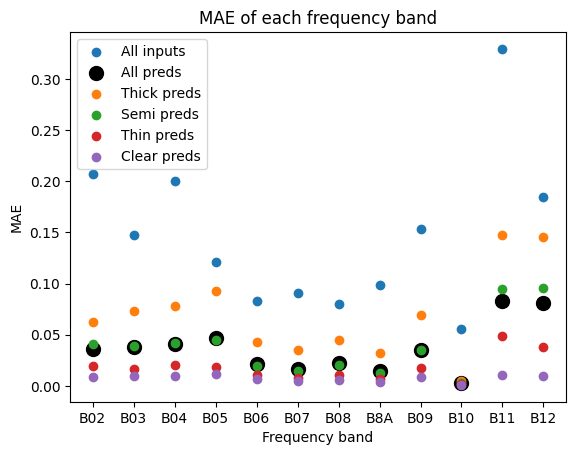

In [55]:
#Find and print MAE of each band
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-preds_total[:,:,est]),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred[:,:,est]),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred[:,:,est]),axis=0)
MAE_col_semi = np.mean(np.abs(semi_true-semi_pred[:,:,est]),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred[:,:,est]),axis=0)
MAE_cloud_tot = np.mean(np.abs(y_test.to_numpy()-X_test.to_numpy()[:,:12]),axis=0)

x=np.arange(np.size(MAE_col_tot))
plt.figure()
plt.scatter(x,MAE_cloud_tot)
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_thick)
plt.scatter(x,MAE_col_semi)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_clear)

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['All inputs','All preds','Thick preds','Semi preds','Thin preds','Clear preds'])
plt.show()

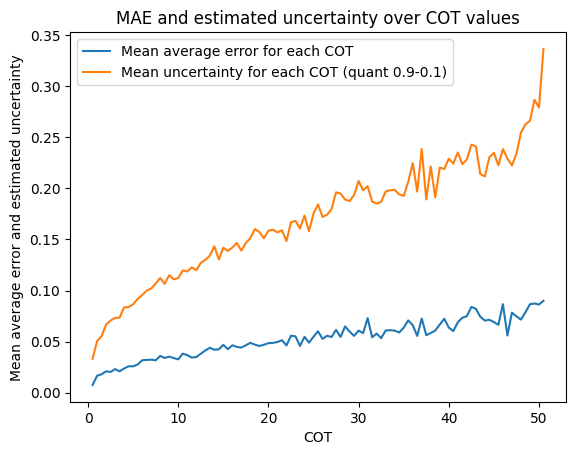

In [56]:
#find sorted numpy indices and sort COT array
COTidx=np.argsort(COTs)
COT_sorted = COTs[COTidx]

#sort numpy test and preds by COT
y_test_np_sort=y_test.to_numpy()[COTidx,:]
y_pred_sort=preds_total[COTidx,:,:]

#Find errors and uncs for chosen bands
all_bands=True
if all_bands:
    errors = np.mean(np.abs(y_test_np_sort[:,:]-y_pred_sort[:,:,est]),axis=1)
    uncs = np.mean(y_pred_sort[:,:,-1]-y_pred_sort[:,:,0],axis=1)
else:
    band = 9
    errors = np.abs(y_test_np_sort[:,band]-y_pred_sort[:,band,est])
    uncs = y_pred_sort[:,band,-1]-y_pred_sort[:,band,0]

#sort errors and uncs into bins based on COT
COTedges=np.linspace(0,50.5,102)
err_bins = np.zeros(len(COTedges)-1)
unc_bins = np.zeros(len(COTedges)-1)
bin_freq = np.zeros(len(COTedges)-1)

for i in range(len(COT_sorted)):
    for j in range(len(COTedges)-1):   
        if COT_sorted[i] >= COTedges[j] and COT_sorted[i] < COTedges[j+1]:
            err_bins[j] = err_bins[j] + errors[i]
            unc_bins[j] = unc_bins[j] + uncs[i]
            bin_freq[j] = bin_freq[j] + 1
            break

#Find mean errs and uncs in each bin
err_mean_bins = err_bins/bin_freq
unc_mean_bins = unc_bins/bin_freq

x_COT=COTedges[:-1]+0.5
plt.figure()
plt.plot(x_COT,err_mean_bins)
plt.plot(x_COT,unc_mean_bins)
plt.title('MAE and estimated uncertainty over COT values')
plt.legend(['Mean average error for each COT','Mean uncertainty for each COT (quant 0.9-0.1)'])
plt.xlabel('COT')
plt.ylabel('Mean average error and estimated uncertainty')
plt.show()



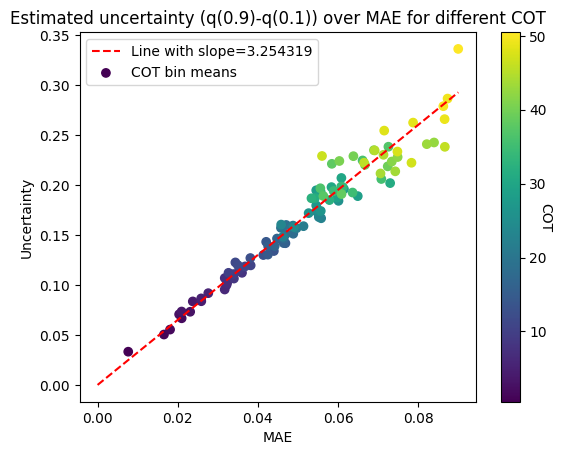

In [57]:
plt.figure()
slope=np.mean(np.divide(unc_mean_bins,err_mean_bins))
line = plt.plot(np.linspace(0,0.09,20),slope*np.linspace(0,0.09,20),'r--')
sc = plt.scatter(err_mean_bins,unc_mean_bins,c=x_COT)
plt.title('Estimated uncertainty (q(0.9)-q(0.1)) over MAE for different COT')
plt.xlabel('MAE')
plt.ylabel('Uncertainty')
plt.legend(['Line with slope=%f' %slope,'COT bin means'])
cb = plt.colorbar(sc)
cb.set_label('COT', rotation=270)
plt.show()

In [58]:
print(df.Surface_Desc_Dumb.unique())
#Find all test surfaces
surfs=np.array(df_test['Surface_Desc_Dumb'])
#Divide into bins depending on COT
waterice_true = y_test.to_numpy()[(surfs=='water/ice'),:]
waterice_pred = preds_total[(surfs=='water/ice'),:,:]
frostsnow_true = y_test.to_numpy()[(surfs=='frost/snow'),:]
frostsnow_pred = preds_total[(surfs=='frost/snow'),:,:]
veg_true = y_test.to_numpy()[(surfs=='vegetation'),:]
veg_pred = preds_total[(surfs=='vegetation'),:,:]
soil_true = y_test.to_numpy()[(surfs=='soil'),:]
soil_pred = preds_total[(surfs=='soil'),:,:]
rock_true = y_test.to_numpy()[(surfs=='rock'),:]
rock_pred = preds_total[(surfs=='rock'),:,:]
nonph_true = y_test.to_numpy()[(surfs=='nonphotosyntheticvegetation'),:]
nonph_pred = preds_total[(surfs=='nonphotosyntheticvegetation'),:,:]

['frost/snow' 'vegetation' 'soil' 'rock' 'nonphotosyntheticvegetation'
 'water/ice']


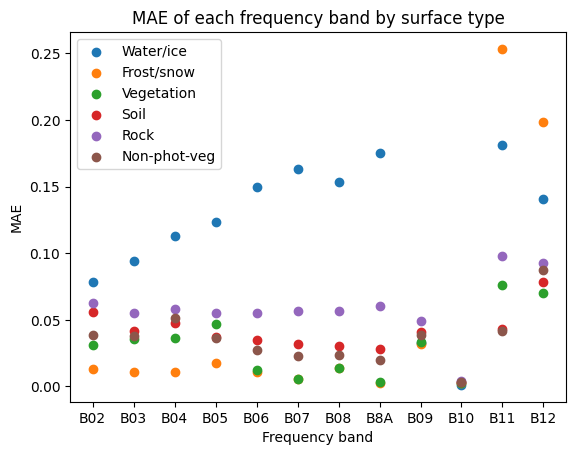

In [59]:
#Find and print MAE of each surface type
MAE_waterice = np.mean(np.abs(waterice_true-waterice_pred[:,:,est]),axis=0)
MAE_frostsnow = np.mean(np.abs(frostsnow_true-frostsnow_pred[:,:,est]),axis=0)
MAE_veg = np.mean(np.abs(veg_true-veg_pred[:,:,est]),axis=0)
MAE_soil = np.mean(np.abs(soil_true-soil_pred[:,:,est]),axis=0)
MAE_rock = np.mean(np.abs(rock_true-rock_pred[:,:,est]),axis=0)
MAE_nonphot = np.mean(np.abs(nonph_true-nonph_pred[:,:,est]),axis=0)

x=np.arange(np.size(MAE_waterice))
plt.figure()
plt.scatter(x,MAE_waterice)
plt.scatter(x,MAE_frostsnow)
plt.scatter(x,MAE_veg)
plt.scatter(x,MAE_soil)
plt.scatter(x,MAE_rock)
plt.scatter(x,MAE_nonphot)

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band by surface type')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['Water/ice','Frost/snow','Vegetation','Soil','Rock','Non-phot-veg'])
plt.show()

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


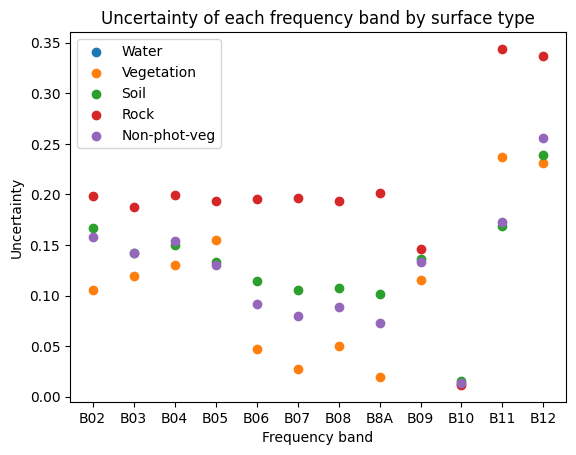

In [60]:
#Find and print Uncertainty of each surface type
Unc_water = np.mean(np.abs(water_pred[:,:,2]-water_pred[:,:,0]),axis=0)
Unc_veg = np.mean(np.abs(veg_pred[:,:,2]-veg_pred[:,:,0]),axis=0)
Unc_soil = np.mean(np.abs(soil_pred[:,:,2]-soil_pred[:,:,0]),axis=0)
Unc_rock = np.mean(np.abs(rock_pred[:,:,2]-rock_pred[:,:,0]),axis=0)
Unc_nonphot = np.mean(np.abs(nonph_pred[:,:,2]-nonph_pred[:,:,0]),axis=0)

x=np.arange(np.size(MAE_water))
plt.figure()
plt.scatter(x,Unc_water)
plt.scatter(x,Unc_veg)
plt.scatter(x,Unc_soil)
plt.scatter(x,Unc_rock)
plt.scatter(x,Unc_nonphot)

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Uncertainty of each frequency band by surface type')
plt.xlabel('Frequency band')
plt.ylabel('Uncertainty')
plt.legend(['Water','Vegetation','Soil','Rock','Non-phot-veg'])
plt.show()

In [61]:
print(df.Cloud_Type.unique())
#Find all test surfaces
ctypes=np.array(df_test['Cloud_Type'])
#Divide into bins depending on COT
true_0 = y_test.to_numpy()[(ctypes==0),:]
pred_0 = preds_total[(ctypes==0),:,:]
true_1 = y_test.to_numpy()[(ctypes==1),:]
pred_1 = preds_total[(ctypes==1),:,:]
true_2 = y_test.to_numpy()[(ctypes==2),:]
pred_2 = preds_total[(ctypes==2),:,:]
true_3 = y_test.to_numpy()[(ctypes==3),:]
pred_3 = preds_total[(ctypes==3),:,:]
true_4 = y_test.to_numpy()[(ctypes==4),:]
pred_4 = preds_total[(ctypes==4),:,:]
true_5 = y_test.to_numpy()[(ctypes==5),:]
pred_5 = preds_total[(ctypes==5),:,:]
true_6 = y_test.to_numpy()[(ctypes==6),:]
pred_6 = preds_total[(ctypes==6),:,:]
true_mix = y_test.to_numpy()[(ctypes>6),:]
pred_mix = preds_total[(ctypes>6),:,:]

[ 3  2  1  5  4  0  6  7 11  8 10  9]


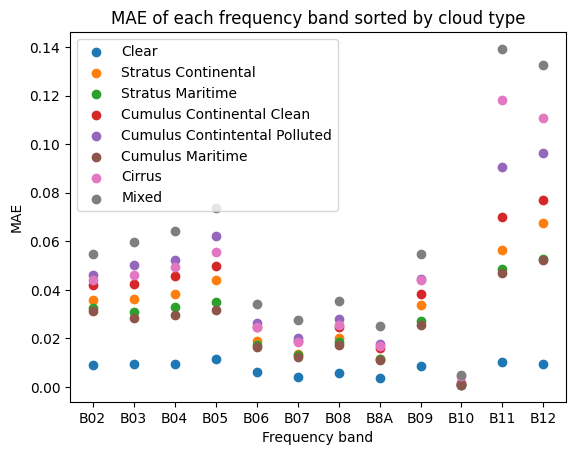

In [62]:
#Find and print MAE of each surface type
MAE_0 = np.mean(np.abs(true_0-pred_0[:,:,est]),axis=0)
MAE_1 = np.mean(np.abs(true_1-pred_1[:,:,est]),axis=0)
MAE_2 = np.mean(np.abs(true_2-pred_2[:,:,est]),axis=0)
MAE_3 = np.mean(np.abs(true_3-pred_3[:,:,est]),axis=0)
MAE_4 = np.mean(np.abs(true_4-pred_4[:,:,est]),axis=0)
MAE_5 = np.mean(np.abs(true_5-pred_5[:,:,est]),axis=0)
MAE_6 = np.mean(np.abs(true_6-pred_6[:,:,est]),axis=0)
MAE_mix= np.mean(np.abs(true_mix-pred_mix[:,:,est]),axis=0)

x=np.arange(np.size(MAE_0))
plt.figure()
plt.scatter(x,MAE_0)
plt.scatter(x,MAE_1)
plt.scatter(x,MAE_2)
plt.scatter(x,MAE_3)
plt.scatter(x,MAE_4)
plt.scatter(x,MAE_5)
plt.scatter(x,MAE_6)
plt.scatter(x,MAE_mix)

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band sorted by cloud type')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['Clear','Stratus Continental','Stratus Maritime','Cumulus Continental Clean','Cumulus Contintental Polluted','Cumulus Maritime','Cirrus','Mixed'],loc='upper left')
plt.show()

In [63]:
#Divide into bins depending on ctype
true_0 = y_test.to_numpy()[(ctypes==0) & (COTs < 3.6) ,:]
pred_0 = preds_total[(ctypes==0) & (COTs < 3.6),:,:]
true_1 = y_test.to_numpy()[(ctypes==1) & (COTs < 3.6),:]
pred_1 = preds_total[(ctypes==1) & (COTs < 3.6),:,:]
true_2 = y_test.to_numpy()[(ctypes==2) & (COTs < 3.6),:]
pred_2 = preds_total[(ctypes==2) & (COTs < 3.6),:,:]
true_3 = y_test.to_numpy()[(ctypes==3) & (COTs < 3.6),:]
pred_3 = preds_total[(ctypes==3) & (COTs < 3.6),:,:]
true_4 = y_test.to_numpy()[(ctypes==4) & (COTs < 3.6),:]
pred_4 = preds_total[(ctypes==4) & (COTs < 3.6),:,:]
true_5 = y_test.to_numpy()[(ctypes==5) & (COTs < 3.6),:]
pred_5 = preds_total[(ctypes==5) & (COTs < 3.6),:,:]
true_6 = y_test.to_numpy()[(ctypes==6) & (COTs < 3.6),:]
pred_6 = preds_total[(ctypes==6) & (COTs < 3.6),:,:]
true_mix = y_test.to_numpy()[(ctypes==7) & (COTs < 3.6),:]
pred_mix = preds_total[(ctypes==7) & (COTs < 3.6),:,:]

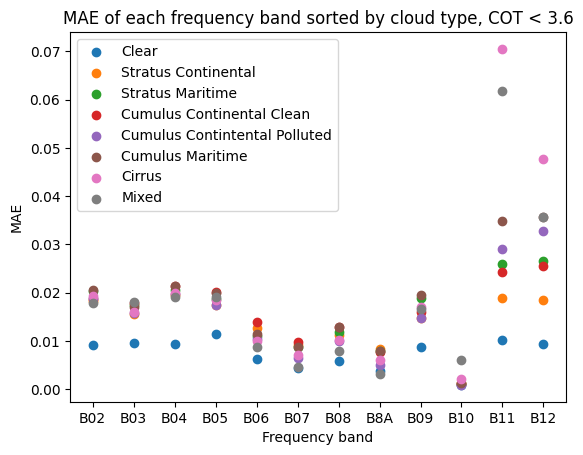

In [64]:
#Find and print MAE of each surface type
MAE_0 = np.mean(np.abs(true_0-pred_0[:,:,est]),axis=0)
MAE_1 = np.mean(np.abs(true_1-pred_1[:,:,est]),axis=0)
MAE_2 = np.mean(np.abs(true_2-pred_2[:,:,est]),axis=0)
MAE_3 = np.mean(np.abs(true_3-pred_3[:,:,est]),axis=0)
MAE_4 = np.mean(np.abs(true_4-pred_4[:,:,est]),axis=0)
MAE_5 = np.mean(np.abs(true_5-pred_5[:,:,est]),axis=0)
MAE_6 = np.mean(np.abs(true_6-pred_6[:,:,est]),axis=0)
MAE_mix= np.mean(np.abs(true_mix-pred_mix[:,:,est]),axis=0)

x=np.arange(np.size(MAE_0))
plt.figure()
plt.scatter(x,MAE_0)
plt.scatter(x,MAE_1)
plt.scatter(x,MAE_2)
plt.scatter(x,MAE_3)
plt.scatter(x,MAE_4)
plt.scatter(x,MAE_5)
plt.scatter(x,MAE_6)
plt.scatter(x,MAE_mix)

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band sorted by cloud type, COT < 3.6')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['Clear','Stratus Continental','Stratus Maritime','Cumulus Continental Clean','Cumulus Contintental Polluted','Cumulus Maritime','Cirrus','Mixed'],loc='upper left')
plt.show()

In [65]:
#Find cases where the predicted uncertainty span does not include the +-20% of true value limit
fail_list=[]
fail_band=[]
fail_COT=[]
for i in range(df_test.to_numpy().shape[0]):
    for j in range(len(y_test.columns)):
        if np.abs(y_test.to_numpy()[i,j]-preds_total[i,j,1])/(preds_total[i,j,2]-preds_total[i,j,0]) > 1.5:
        #if preds_total[i,j,0] > y_test.to_numpy()[i,j]*1.2 or preds_total[i,j,2] < y_test.to_numpy()[i,j]*0.8:
            fail_list.append(i)
            fail_band.append(j)
            fail_COT.append(df['COT'][df_test.index[i]])

#Remove duplicates
fail_list = np.unique(fail_list)
#Turn into df indices
fail_list = df_test.index[fail_list]

print(len(fail_list))

626


In [66]:
#Create df with only fails
fail_df = df.iloc[fail_list,:]
#Find mean COTs
print('mean COT is: ' +str(np.mean(df['COT'])))
print('mean COT for fails is: ' +str(np.mean(fail_df['COT'])))


mean COT is: 14.770915859999999
mean COT for fails is: 23.866685303514373


B02 culprit in 10.702875399361023% of failed cases
B03 culprit in 2.7156549520766773% of failed cases
B04 culprit in 12.300319488817891% of failed cases
B05 culprit in 2.3961661341853033% of failed cases
B06 culprit in 19.169329073482427% of failed cases
B07 culprit in 13.099041533546325% of failed cases
B08 culprit in 7.507987220447284% of failed cases
B8A culprit in 17.891373801916934% of failed cases
B09 culprit in 13.738019169329073% of failed cases
B10 culprit in 21.405750798722046% of failed cases
B11 culprit in 20.287539936102238% of failed cases
B12 culprit in 12.939297124600639% of failed cases


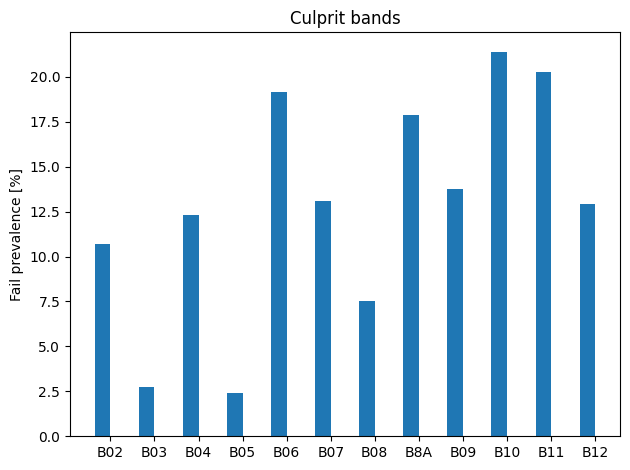

In [67]:
bands=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12']
band_fail_count=np.zeros(len(bands))
for b in range(len(bands)):
    band_fail_count[b] = sum(np.array(fail_band)==b)
    print(str(bands[b]) + ' culprit in '+str(band_fail_count[b]*100/len(fail_list))+ '% of failed cases')

x = np.arange(len(bands))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x - width/2, band_fail_count*100/len(fail_list), width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fail prevalence [%]')
ax.set_title('Culprit bands')
ax.set_xticks(x)
ax.set_xticklabels(bands)
fig.tight_layout()

plt.show()

B02 culprit in 2.3529411764705883% of failed cases
B03 culprit in 1.1764705882352942% of failed cases
B04 culprit in 3.5294117647058822% of failed cases
B05 culprit in 0.0% of failed cases
B06 culprit in 21.176470588235293% of failed cases
B07 culprit in 11.764705882352942% of failed cases
B08 culprit in 7.0588235294117645% of failed cases
B8A culprit in 16.470588235294116% of failed cases
B09 culprit in 2.3529411764705883% of failed cases
B10 culprit in 7.0588235294117645% of failed cases
B11 culprit in 43.529411764705884% of failed cases
B12 culprit in 17.647058823529413% of failed cases


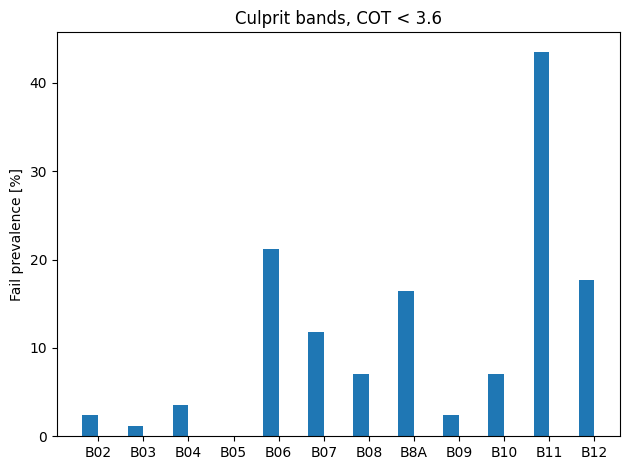

In [68]:
band_fail_count_thin=np.zeros(len(bands))
for b in range(len(bands)):
    band_fail_count_thin[b] = sum((np.array(fail_band)==b) & (np.array(fail_COT) < 3.6))
    print(str(bands[b]) + ' culprit in '+str(band_fail_count_thin[b]*100/len(np.array(fail_df[fail_df['COT']<3.6]['Surface_Desc_Dumb'])))+ '% of failed cases')

x = np.arange(len(bands))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x - width/2, band_fail_count_thin*100/len(np.array(fail_df[fail_df['COT']<3.6]['Surface_Desc_Dumb'])), width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fail prevalence [%]')
ax.set_title('Culprit bands, COT < 3.6')
ax.set_xticks(x)
ax.set_xticklabels(bands)
fig.tight_layout()

plt.show()

frost/snow: total: 4.035%, failed: 1.9169329073482428%
nonphotosyntheticvegetation: total: 8.03%, failed: 9.26517571884984%
rock: total: 10.135%, failed: 18.849840255591054%
soil: total: 5.32%, failed: 6.5495207667731625%
vegetation: total: 70.665%, failed: 61.18210862619808%
water/ice: total: 1.815%, failed: 2.236421725239617%


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (6,).

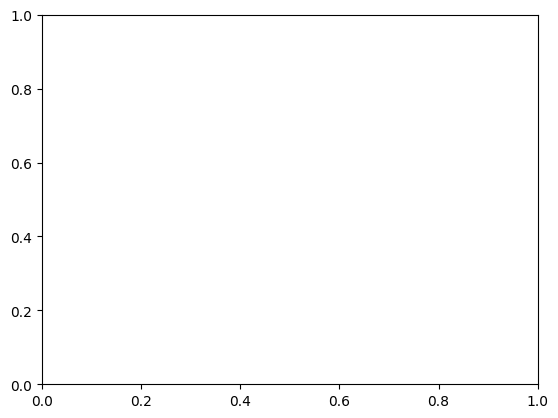

In [69]:
surfs_tot=np.array(df_test['Surface_Desc_Dumb'])
unique_surf_tot, count_surf_tot = np.unique(surfs_tot, return_counts=True)

count_surf_fail = np.zeros(len(unique_surf_tot))
for i in range(len(unique_surf_tot)):
    count_surf_fail[i] = sum(np.array(fail_df['Surface_Desc_Dumb'])==unique_surf_tot[i])
    print(unique_surf_tot[i]+': total: '+str(count_surf_tot[i]/200)+'%, failed: '+str(count_surf_fail[i]*100/len(fail_list))+'%')

labels=['Non-phot. veg.','Rock','Soil','Veg.','Water']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, count_surf_tot/200, width, label='Total')
rects2 = ax.bar(x + width/2, count_surf_fail*100/len(fail_list), width, label='Fails')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prevalence [%]')
ax.set_title('Surface prevalence, total and fails, all points')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

frost/snow: total: 66.69009135628953%, failed: 66.2125340599455%
water/ice: total: 33.30990864371047%, failed: 33.787465940054496%
Out of total 367 thin fails
7115 thin test points


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (2,).

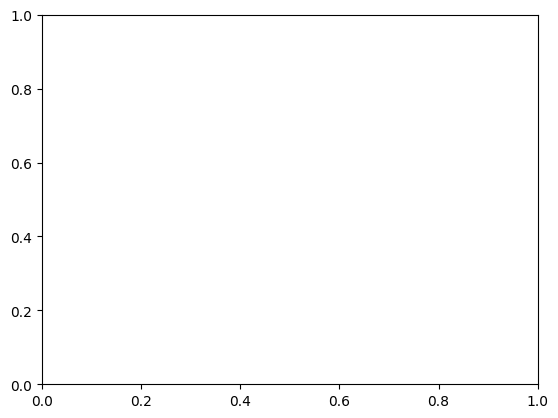

In [ ]:

surfs_test_thin = np.array(df_test[df_test['COT']<3.6]['Surface_Desc_Dumb'])
unique_surf_thin, count_surf_thin = np.unique(surfs_test_thin, return_counts=True)

count_surf_fail_thin = np.zeros(len(unique_surf_thin))
for i in range(len(unique_surf_thin)):
    count_surf_fail_thin[i] = sum(np.array((fail_df['Surface_Desc_Dumb'])==unique_surf_tot[i]) & (np.array(fail_df['COT'])<3.6))
    print(unique_surf_thin[i]+': total: '+str(count_surf_thin[i]*100/sum(count_surf_thin))+'%, failed: '+str(count_surf_fail_thin[i]*100/len(np.array(fail_df[fail_df['COT']<3.6]['Surface_Desc_Dumb'])))+'%')

print('Out of total '+str(len(np.array(fail_df[fail_df['COT']<3.6]['Surface_Desc_Dumb'])))+' thin fails')
print(str(len(np.array(df_test[df_test['COT']<3.6]['Surface_Desc_Dumb'])))+' thin test points')

labels=['Non-phot. veg.','Rock','Soil','Veg.','Water']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, count_surf_thin*100/sum(count_surf_thin), width, label='Total')
rects2 = ax.bar(x + width/2, count_surf_fail_thin*100/len(np.array(fail_df[fail_df['COT']<3.6]['Surface_Desc_Dumb'])), width, label='Fails')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prevalence [%]')
ax.set_title('Surface prevalence, total and fails, COT < 3.6')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

0: total: 25.265%, failed: 31.092436974789916%
1: total: 4.855%, failed: 2.6260504201680672%
2: total: 4.66%, failed: 1.8907563025210083%
3: total: 4.845%, failed: 2.4159663865546217%
4: total: 4.965%, failed: 4.201680672268908%
5: total: 4.97%, failed: 3.046218487394958%
6: total: 25.035%, failed: 19.222689075630253%
7: total: 25.405%, failed: 35.50420168067227%


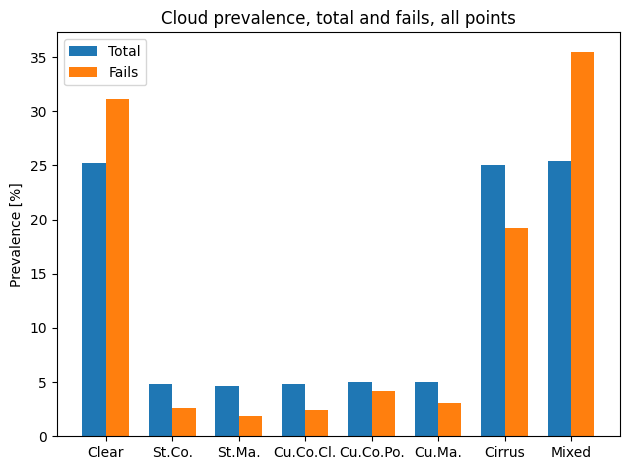

In [ ]:
clouds_tot=np.array(df_test['Cloud_Type'])
for i in range(len(clouds_tot)):
    if clouds_tot[i]>6:
        clouds_tot[i]=7
unique_cloud_tot, count_cloud_tot = np.unique(clouds_tot, return_counts=True)

count_cloud_fail = np.zeros(len(unique_cloud_tot))
for i in range(len(unique_cloud_tot)):
    if unique_cloud_tot[i] == 7:
        count_cloud_fail[i] = sum(np.array(fail_df['Cloud_Type'])>=unique_cloud_tot[i])
    else:
        count_cloud_fail[i] = sum(np.array(fail_df['Cloud_Type'])==unique_cloud_tot[i])
    print(str(unique_cloud_tot[i])+': total: '+str(count_cloud_tot[i]/200)+'%, failed: '+str(count_cloud_fail[i]*100/len(fail_list))+'%')

labels=['Clear','St.Co.','St.Ma.','Cu.Co.Cl.','Cu.Co.Po.','Cu.Ma.','Cirrus','Mixed']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, count_cloud_tot/200, width, label='Total')
rects2 = ax.bar(x + width/2, count_cloud_fail*100/len(fail_list), width, label='Fails')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prevalence [%]')
ax.set_title('Cloud prevalence, total and fails, all points')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

Clear: total: 71.01897399859452%, failed: 80.65395095367847%
St.Co.: total: 2.69852424455376%, failed: 2.1798365122615806%
St.Ma.: total: 3.668306394940267%, failed: 1.6348773841961852%
Cu.Co.Cl.: total: 2.19255094869993%, failed: 1.9073569482288828%
Cu.Co.Po.: total: 1.4195361911454674%, failed: 0.8174386920980926%
Cu.Ma.: total: 4.089950808151792%, failed: 2.997275204359673%
Cirrus: total: 11.749824314827828%, failed: 7.356948228882834%
Mixed: total: 3.162333099086437%, failed: 2.4523160762942777%


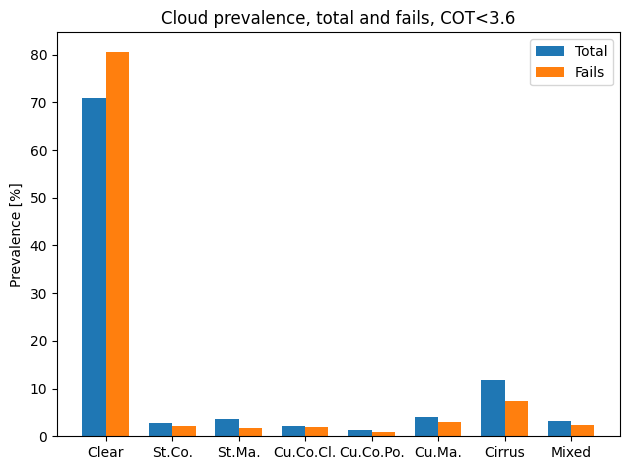

In [ ]:
clouds_test_thin = np.array(df_test[df_test['COT']<3.6]['Cloud_Type'])
for i in range(len(clouds_test_thin)):
    if clouds_test_thin[i]>6:
        clouds_test_thin[i]=7
unique_cloud_thin, count_cloud_thin = np.unique(clouds_test_thin, return_counts=True)

count_cloud_fail_thin = np.zeros(len(unique_cloud_thin))
for i in range(len(unique_cloud_thin)):
    if unique_cloud_thin[i] == 7:
        count_cloud_fail_thin[i] = sum(np.array((fail_df['Cloud_Type'])>=unique_cloud_thin[i]) & (np.array(fail_df['COT'])<3.6))
    else:
        count_cloud_fail_thin[i] = sum(np.array((fail_df['Cloud_Type'])==unique_cloud_thin[i]) & (np.array(fail_df['COT'])<3.6))
    print(labels[i]+': total: '+str(count_cloud_thin[i]*100/sum(count_cloud_thin))+'%, failed: '+str(count_cloud_fail_thin[i]*100/len(np.array(fail_df[fail_df['COT']<3.6]['Surface_Desc_Dumb'])))+'%')

labels=['Clear','St.Co.','St.Ma.','Cu.Co.Cl.','Cu.Co.Po.','Cu.Ma.','Cirrus','Mixed']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, count_cloud_thin*100/sum(count_cloud_thin), width, label='Total')
rects2 = ax.bar(x + width/2, count_cloud_fail_thin*100/len(np.array(fail_df[fail_df['COT']<3.6]['Surface_Desc_Dumb'])), width, label='Fails')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prevalence [%]')
ax.set_title('Cloud prevalence, total and fails, COT<3.6')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

In [ ]:
#Find feature to error coeffs
df_cloud_dum = pd.get_dummies(df_test['Cloud_Type'])
df_surf_dum = pd.get_dummies(df_test['Surface_Desc_Dumb'])
df_coef = pd.concat([df_test,df_cloud_dum,df_surf_dum],axis=1)
df_coef = df_coef.drop(['Profile_ID','Surface_Desc','Cloud_Type','Surface_Desc_Dumb','Cloud_B01','Clear_B01'],axis=1)
unc = np.mean(np.abs(preds_total[:,:,-1]-preds_total[:,:,0]),axis=1)
mae = np.mean(np.abs(y_test.to_numpy()-preds_total[:,:,est]),axis=1)
df_coef = df_coef.assign(UNC=unc)
df_coef = df_coef.assign(MAE=mae)
x_coef = df_coef.values.astype(float)
err_corrs = np.corrcoef(x_coef.T)[:,-1]
for i in range(len(err_corrs)):
    print('Feature: '+str(df_coef.columns[i])+' has corr coef: '+str(err_corrs[i]))

Feature: Cloud_B02 has corr coef: 0.436784411860405
Feature: Cloud_B03 has corr coef: 0.34794120389388
Feature: Cloud_B04 has corr coef: 0.3136924808623324
Feature: Cloud_B05 has corr coef: 0.23386502001006862
Feature: Cloud_B06 has corr coef: -0.030784271134676616
Feature: Cloud_B07 has corr coef: -0.10528760031172511
Feature: Cloud_B08 has corr coef: -0.06542074337624096
Feature: Cloud_B08A has corr coef: -0.15256850634590685
Feature: Cloud_B09 has corr coef: 0.2917411645841344
Feature: Cloud_B10 has corr coef: 0.28868349690872536
Feature: Cloud_B11 has corr coef: -0.3992546901950579
Feature: Cloud_B12 has corr coef: -0.36954472490041845
Feature: Clear_B02 has corr coef: -0.05026040196209676
Feature: Clear_B03 has corr coef: -0.10769749698436694
Feature: Clear_B04 has corr coef: -0.11422075812683312
Feature: Clear_B05 has corr coef: -0.15912468451590198
Feature: Clear_B06 has corr coef: -0.22597100065090225
Feature: Clear_B07 has corr coef: -0.23141689284738473
Feature: Clear_B08 has

In [ ]:
err_corrs = np.corrcoef(x_coef.T)[:,-2]
for i in range(len(err_corrs)):
    print('Feature: '+str(df_coef.columns[i])+' has corr coef: '+str(err_corrs[i]))

Feature: Cloud_B02 has corr coef: 0.6620454298119722
Feature: Cloud_B03 has corr coef: 0.5359130878143877
Feature: Cloud_B04 has corr coef: 0.48470084418098275
Feature: Cloud_B05 has corr coef: 0.36827727414485034
Feature: Cloud_B06 has corr coef: -0.01781653175458923
Feature: Cloud_B07 has corr coef: -0.12821661027651216
Feature: Cloud_B08 has corr coef: -0.0737674121750982
Feature: Cloud_B08A has corr coef: -0.1976144982961456
Feature: Cloud_B09 has corr coef: 0.4482285038831024
Feature: Cloud_B10 has corr coef: 0.4419152756475561
Feature: Cloud_B11 has corr coef: -0.6060446214329969
Feature: Cloud_B12 has corr coef: -0.5583255419502325
Feature: Clear_B02 has corr coef: -0.052940810112169855
Feature: Clear_B03 has corr coef: -0.10919795935859616
Feature: Clear_B04 has corr coef: -0.10570102938009134
Feature: Clear_B05 has corr coef: -0.15950465558862306
Feature: Clear_B06 has corr coef: -0.20875867722848068
Feature: Clear_B07 has corr coef: -0.1957701853134629
Feature: Clear_B08 has 